# Group Assignment 1
October 6 2022

**Team Members**
- Rohan Agarwal
- Meilin Lyu
- Eric Chao

In this assignment we perform the following tasks:
1. Implementation of KNN and DT models for classification
2. Acquiring, preprocessing and analyzing the data of two different datasets
3. Running experiments:  
  - Validation
  - Cross validation
  - Hyperparameter tuning
  - Evaluation on Test Set
4. Model Comparison

**IMPORTANT NOTE:** Before you run this notebook, please download the [Messidor Images Data set](https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set) and drag the `.arff` file to the left "Files" Menu.

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline                                  
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

### Utility functions and Cost functions

In [53]:
# Utility to plot features' distribution
def draw_distributions(dataframe, features, n_rows, n_cols):
  fig = plt.figure(figsize=(15,15))
  for i, feat in enumerate(features):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    dataframe[feat].hist(bins=10, ax=ax)
    ax.set_title(feat+" Distribution")
  fig.tight_layout()
  plt.show()


In [54]:
#Utility to scale all features to be within [0,1]
from sklearn.preprocessing import MinMaxScaler
def normalize_features(dataframe, TARGET): #TARGET is the string that represents the column name of the target feature

  X = dataframe.loc[:, dataframe.columns != TARGET]
  # y = dataframe.loc[:, TARGET]

  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
  return X_scaled

In [55]:
# Utility to plot accuracy as a function of a parameter
def plot_validation(model_choices, validation_accuracies, best_validation_param, test_accuracy, param_label, file_name=None):
  plt.clf()
  plt.plot(model_choices, validation_accuracies, marker='o', color='blue', label='validation')
  plt.plot(best_validation_param, test_accuracy, marker='*', color='red', label='testing')
  plt.xlabel(param_label)
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  if file_name:
    plt.savefig(file_name)

In [56]:
from numpy.linalg import norm

def cosineDist(x1, x2):
  # x1 is a matrix (1, M, F)
  # x2 is a matrix (N, 1, F)
  # returns a matrix (NxM)
  M = x1.shape[1]
  N = x2.shape[0]

  distances = np.zeros((N,M))
  for i in range(N):  # for every row x1
    for j in range(M):  # for every row x2
      u = x2[i,0,:]
      v = x1[0,j,:]
      res = 1 - np.dot(u,v) / (norm(u)*norm(v))
      distances[i][j] = res
  
  return distances

##### Decision Tree Cost Functions

In [57]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

# KNN and DT Implementations

For this assignment, we write our own implementations for K-Nearest-Neighbors and Decision Tree for Classification.

For practical purposes will implement the same methods.
- `fit`: receives a training set to prepare the model for prediction
- `predict`: receives a test set and returns a vector of class probabilities for every test set example.

### KNN

In [58]:
class KNN:
    # COST FUNCTIONS AVAILABLE
    euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
    manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
    cosine = cosineDist  

    def __init__(self, K=1, dist_fn=euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        '''
        Store the training data and record the number of classes.
        X and y should are expected to be Numpy Arrays. 
        '''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        '''
        Receives a Numpy Array of N test observations.
        Returns an array of N class probabilities of the test observations and 
        a NxK matrix with the indexes of the nearest neighbors of each test observation
        '''
        num_test = x_test.shape[0]
        # calculate distance between the training & test samples: array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        y_prob /= self.K
        return y_prob, knns

    def predict_labels(self, x_test):
        '''
        Receives a Numpy Array of N test observations.
        Returns an array of N class probabilities of the test observations and 
        a NxK matrix with the indexes of the nearest neighbors of each test observation
        '''
        num_test = x_test.shape[0]
        num_train = x_test.shape[0]
        # calculate distance between the training & test samples: array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        y_pred = np.argmax(y_prob, axis=-1)
        return y_pred, knns
    
    def evaluate_acc(self, predicted_y, true_y):
      '''
      Takes two Numpy arrays with equal length: true label values and predicted label values
      Both arrays are expected to be integer values.
      Returns the classification accuracy
      '''
      if len(true_y) != len(predicted_y):
        raise ValueError(f"Length mismatch: ({len(true_y)}) vs. ({len(predicted_y)})")
      return (true_y == predicted_y).sum() / len(true_y)


### Decision Tree

In [59]:
class Node:
    """Implements a Node from a Decision Tree for Classification"""
    def __init__(self, data_indices, parent):
        """
        data_indices is a Numpy Array with the observation ID's in the node region
        parent is a pointer to the parent Node of this instance
        """
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

In [60]:
def find_best_split(node, cost_fn):
    """
    Helper function to greedily find the best split for a given decision tree Node.
    Iterates over features and candidate threshold values for the feature,
    returns the pair that minimizes cost function as well as the minimum cost.
    """
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [61]:
class DecisionTree:
    """
    Implements a decision tree for classification.
    Works as a container for the root node and the parameters
    for building the tree.
    """
    gini = cost_gini_index
    misclassif = cost_misclassification
    entropy = cost_entropy

    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def _fit_tree(self, node):
        #This gives the condition for termination of the recursion resulting in a leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        #greedily select the best test by minimizing the cost
        cost, split_feature, split_value = find_best_split(node, self.cost_fn)
        #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
        if np.isinf(cost):
            return
        #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
        #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
        test = node.data[node.data_indices,split_feature] <= split_value
        #store the split feature and value of the node
        node.split_feature = split_feature
        node.split_value = split_value
        #define new nodes which are going to be the left and right child of the present node
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        #recursive call to the _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        #assign the left and right child to present child
        node.left = left
        node.right = right
    
    def fit(self, data, labels):
      self.data = data
      self.labels = labels
      if self.num_classes is None:
          self.num_classes = np.max(labels) + 1
      #below are initialization of the root of the decision tree
      self.root = Node(np.arange(data.shape[0]), None)
      self.root.data = data
      self.root.labels = labels
      self.root.num_classes = self.num_classes
      self.root.depth = 0
      #to recursively build the rest of the tree
      self._fit_tree(self.root)
      return self    

    def predict(self, data_test):
      class_probs = np.zeros((data_test.shape[0], self.num_classes))
      for n, x in enumerate(data_test):
          node = self.root
          #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
          while node.left:
              if x[node.split_feature] <= node.split_value:
                  node = node.left
              else:
                  node = node.right
          #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
          class_probs[n,:] = node.class_prob
      return class_probs

    def evaluate_acc(self, predicted_y, true_y):
      '''
      Takes two Numpy arrays with equal length: true label values and predicted label values
      Returns the classification accuracy
      '''
      if len(true_y) != len(predicted_y):
        raise ValueError(f"Length mismatch: ({len(true_y)}) vs. ({len(predicted_y)})")
      return (true_y == predicted_y).sum() / len(true_y)

In [62]:
def decision_tree_selection(depth_range, leaf_range, X_train_, y_train_, X_valid_, y_valid_, cost_function=DecisionTree.misclassif):
  max_depth = 0
  max_leaf = 0
  max_accuracy = 0
  for depth in range(1,depth_range):
    for leaf in range(1,leaf_range):
      tree = DecisionTree(max_depth=depth, min_leaf_instances=leaf, cost_fn=cost_function) #cost function default to misclassification 
      probs_test = tree.fit(X_train_, y_train_).predict(X_valid_)
      y_pred = np.argmax(probs_test,1)
      accuracy = np.sum(y_pred == y_valid_)/y_valid_.shape[0]
      if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_depth = depth
        max_leaf = leaf
  return max_accuracy, max_depth, max_leaf

# Data Set 1: Diabetes
**Dataset description:**
This dataset contains features extracted from the Messidor image set to predict whether an image contains signs of diabetic retinopathy or not. All features represent either a detected lesion, a descriptive feature of a anatomical part or an image-level descriptor.


## Acquire, Preprocess and Analyze the data

In [63]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
# FIRST download the file and dragging into the Files menu to the left

url = 'messidor_features.arff'
from scipy.io.arff import loadarff
rawData = loadarff(url)
diabetes = pd.DataFrame(rawData[0])
columns = ['quality','retinalAbnormality', 'maDetection05', 'maDetection06', 'maDetection07', 'maDetection08', 'maDetection09', 'maDetection10', 'exudates1', 'exudates2', 'exudates3', 'exudates4', 'exudates5', 'exudates6', 'exudates7', 'exudates8', 'distance', 'diameter', 'amfm', 'DiabeticRetinopathy']
diabetes.columns = columns

# Target label to numeric
diabetes['DiabeticRetinopathy'] = pd.to_numeric(diabetes['DiabeticRetinopathy'])
# 'quality' column is constant
diabetes.drop('quality', inplace=True, axis=1)
#diabetes.isnull().sum() # There are no missing values

TARGET = 'DiabeticRetinopathy'
diabetes_X = diabetes.loc[:, diabetes.columns != TARGET]
diabetes_y = diabetes.loc[:, TARGET]

#### Distribution of the data

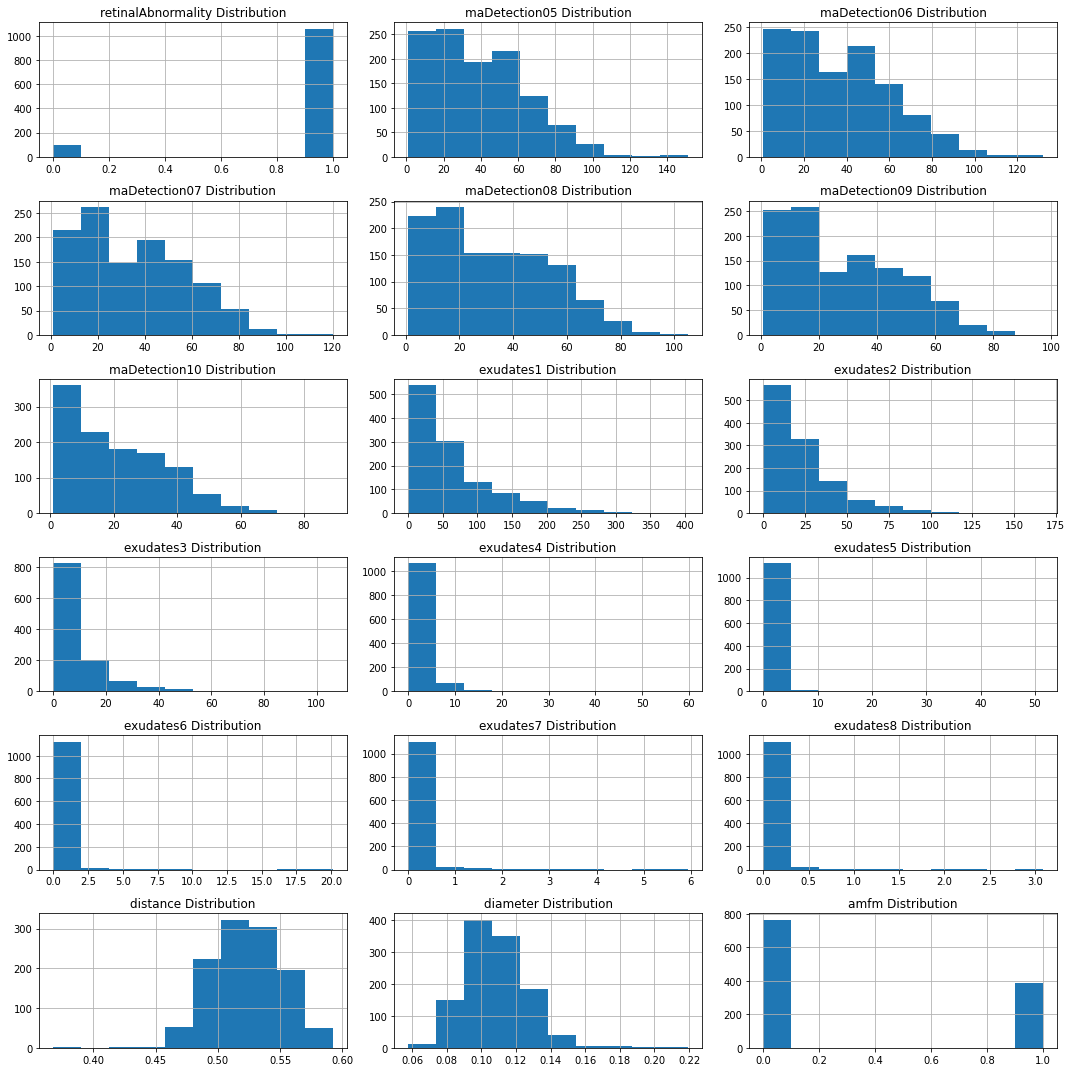

In [64]:
# Feature values Distribution
draw_distributions(diabetes_X, diabetes_X, 6, 3)

- Numerical variables are generally right-skewed. (the tail is to the right).
- Categorical variables only take binary values.

positive: 53.08427454387489 %
negative: 46.91572545612511 %


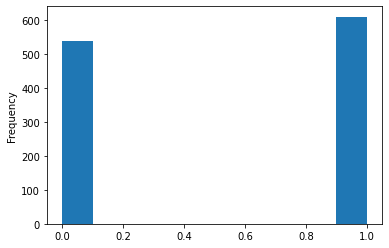

In [65]:
proportion_positive = diabetes['DiabeticRetinopathy'].sum() / diabetes.shape[0]
proportion_negative = 1 - proportion_positive
print("positive:", proportion_positive*100,"%")
print("negative:", proportion_negative*100,'%')
diabetes['DiabeticRetinopathy'].plot.hist() # 53 positive vs 47 negative

## Running Experiments (Diabetes Dataset)


#### Train-Test split

*Note:* KNN is not able to handle both contiguous and discrete features.
One way to make it work is to one-hote encode categorical features and then standardize features including the numerical ones so that they are all in the same range.

In [66]:
from sklearn.model_selection import train_test_split
diabetes_X_scaled = normalize_features(diabetes, TARGET) # values between 0 and 1 
#print the feature shape and classes of hepatitis 
(N,D), C = diabetes_X_scaled.shape, np.max(diabetes_y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

RAND_SEED = 1234
# Split 80/20 train/test
diabetes_train_X_scaled, diabetes_test_X_scaled, diabetes_train_y, diabetes_test_y = \
    train_test_split(diabetes_X_scaled, diabetes_y, test_size=0.2, random_state=RAND_SEED)

# Split 80/20 train/validation
diabetes_train_X_scaled, diabetes_valid_X_scaled, diabetes_train_y, diabetes_valid_y = \
    train_test_split(diabetes_train_X_scaled, diabetes_train_y, test_size=0.2, random_state=RAND_SEED)

proportion_positive = diabetes_train_y.sum() / diabetes_train_y.shape[0]
proportion_negative = 1 - proportion_positive
print("Training set positive:", proportion_positive*100,"%")
print("Training set negative:", proportion_negative*100,'%')
print()
print("Train set size", len(diabetes_train_y))
print("Test set size", len(diabetes_test_y))

instances (N) 	 1151 
 features (D) 	 18 
 classes (C) 	 2
Training set positive: 53.80434782608695 %
Training set negative: 46.19565217391305 %

Train set size 736
Test set size 231


##### Baseline performance
We will compute baseline performance with results from a dummy model predicting with .50 chance 1 or 0.

In [67]:
np.random.seed(0)
N_test = len(diabetes_test_y)

dummy_res = np.random.randint(0, 2, N_test)
print("Observations from test set:", N_test)
baseline = (dummy_res == diabetes_test_y.to_numpy()).sum() / N_test
print("Baseline accuracy (approximation):", baseline)

Observations from test set: 231
Baseline accuracy (approximation): 0.5064935064935064


## KNN - Diabetes

### Validation

Our model implementations work with Numpy arrays, so we must **first convert our working data to Numpy form**.

In [68]:
# Working data to Numpy form
if isinstance(diabetes_train_X_scaled, pd.DataFrame):
  print("Converting working data to Numpy Array")
  diabetes_train_X_scaled = diabetes_train_X_scaled.to_numpy()
  diabetes_train_y = diabetes_train_y.to_numpy()
  diabetes_valid_X_scaled = diabetes_valid_X_scaled.to_numpy()
  diabetes_valid_y = diabetes_valid_y.to_numpy()
  diabetes_test_X_scaled = diabetes_test_X_scaled.to_numpy()
  diabetes_test_y = diabetes_test_y.to_numpy()

if isinstance(diabetes_test_X_scaled, pd.DataFrame):
  print("Converting test data to Numpy Array")
  diabetes_test_X_scaled = diabetes_test_X_scaled.to_numpy()
  diabetes_test_y = diabetes_test_y.to_numpy()

Converting working data to Numpy Array


#### Validation -Euclidean Distance

In [69]:
# EUCLIDEAN
k_to_test = range(1, 21)
benchmark = {}

print("Training set size", len(diabetes_train_y))
print("Validation set size", len(diabetes_valid_y))

COST = KNN.euclidean

# Find best k (number of neighbors)
for k in k_to_test:
  model = KNN(K=k, dist_fn=COST)
  model.fit(diabetes_train_X_scaled, diabetes_train_y)
  y_pred, _ = model.predict_labels(diabetes_valid_X_scaled)
  y_proba, _ = model.predict(diabetes_valid_X_scaled)
  accuracy = model.evaluate_acc(y_pred, diabetes_valid_y)
  benchmark[k] = accuracy

best_k = max(benchmark, key=benchmark.get)
print("Best K with euclidean distance:", best_k, "with acc:", benchmark.get(best_k))

Training set size 736
Validation set size 184
Best K with euclidean distance: 13 with acc: 0.7228260869565217


Test accuracy with K=13 and Euclidean distance: 0.696969696969697


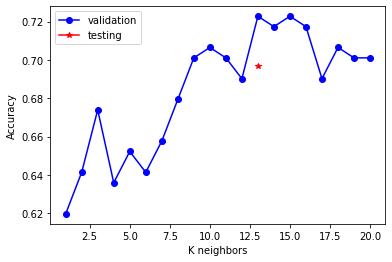

In [70]:
knn = KNN(K=best_k, dist_fn=COST)
knn.fit(diabetes_train_X_scaled, diabetes_train_y)

y_test_pred, _ = knn.predict_labels(diabetes_test_X_scaled)
test_accuracy = knn.evaluate_acc(y_test_pred, diabetes_test_y)
print(f"Test accuracy with K={best_k} and Euclidean distance: {test_accuracy}")

plot_validation(list(benchmark.keys()), list(benchmark.values()), best_k, test_accuracy, param_label="K neighbors")
plt.savefig("knn_diabetes_euclidean_accuracy.png")

#### Validation - Manhattan Distance

In [71]:
# MANHATTAN DISTANCE
k_to_test = range(1, 21)
benchmark = {}

print("Training set size", len(diabetes_train_y))
print("Validation set size", len(diabetes_valid_y))

COST = KNN.manhattan

for k in k_to_test:
  model = KNN(K=k, dist_fn=COST)
  model.fit(diabetes_train_X_scaled, diabetes_train_y)
  y_pred, _ = model.predict_labels(diabetes_valid_X_scaled)
  y_proba, _ = model.predict(diabetes_valid_X_scaled)
  accuracy = model.evaluate_acc(y_pred, diabetes_valid_y)
  benchmark[k] = accuracy

best_k = max(benchmark, key=benchmark.get)
print("Best K with Manhattan distance:", best_k, "with acc:", benchmark.get(best_k))

Training set size 736
Validation set size 184
Best K with Manhattan distance: 4 with acc: 0.7228260869565217


Test accuracy with K=4 and Manhattan distance: 0.645021645021645


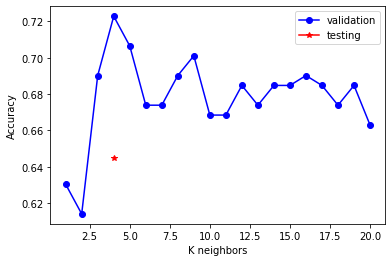

In [72]:
knn = KNN(K=best_k, dist_fn=COST)
knn.fit(diabetes_train_X_scaled, diabetes_train_y)

y_test_pred, _ = knn.predict_labels(diabetes_test_X_scaled)
test_accuracy = knn.evaluate_acc(y_test_pred, diabetes_test_y)
print(f"Test accuracy with K={best_k} and Manhattan distance: {test_accuracy}")

plot_validation(list(benchmark.keys()), list(benchmark.values()), best_k, test_accuracy, param_label="K neighbors")
plt.savefig("knn_diabetes_manhattan_accuracy.png")

#### Validation - Cosine Distance
***Note:*** running this block of code takes a while, since the cosine function implemented is less performant than its Numpy-based counterparts

In [73]:
k_to_test = range(1, 21)
benchmark = {}

print("Training set size", len(diabetes_train_y))
print("Validation set size", len(diabetes_valid_y))

COST = KNN.cosine # own implementation, can still be optimized

for k in k_to_test:
  model = KNN(K=k, dist_fn=COST)
  model.fit(diabetes_train_X_scaled, diabetes_train_y)
  y_pred, _ = model.predict_labels(diabetes_valid_X_scaled)
  y_proba, _ = model.predict(diabetes_valid_X_scaled)
  accuracy = model.evaluate_acc(y_pred, diabetes_valid_y)
  benchmark[k] = accuracy

best_k = max(benchmark, key=benchmark.get)
print("Best K with Cosine distance:", best_k, "with acc:", benchmark.get(best_k))

Training set size 736
Validation set size 184
Best K with Cosine distance: 10 with acc: 0.7282608695652174


Test accuracy with K=10 and Cosine distance: 0.6796536796536796


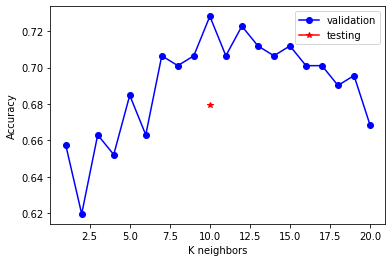

In [74]:
# use the best K to predict test data
knn = KNN(K=best_k, dist_fn=COST)
knn.fit(diabetes_train_X_scaled, diabetes_train_y)

y_test_pred, _ = knn.predict_labels(diabetes_test_X_scaled)
test_accuracy = knn.evaluate_acc(y_test_pred, diabetes_test_y)
print(f"Test accuracy with K={best_k} and Cosine distance: {test_accuracy}")

plot_validation(list(benchmark.keys()), list(benchmark.values()), best_k, test_accuracy, param_label="K neighbors")

**Conclusion:** the best validation accuracy is achieved with **Euclidean** distance as cost and **K=13** neighbors

### KNN Decision Boundary (Diabetes Dataset)

Aftr validating the best parameters we want to visualize our model's decision boundary.

We now plot the decision boundary for KNN. To have an interpretable plot, we will first identify the 2 most important predictors and plot a 2d graph. We use a Random Forest to find the best predictors.


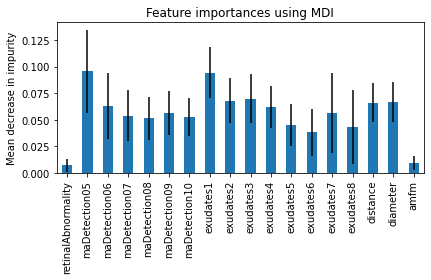

In [75]:
# Top features by Random Forest feature importance
from sklearn.ensemble import RandomForestClassifier
y = diabetes['DiabeticRetinopathy']
X = diabetes.loc[:, diabetes.columns!= 'DiabeticRetinopathy']
forest = RandomForestClassifier(random_state=1234)

forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("knn_diabetes_random_forest_tree.png")

The Random Forest finds the top features to be:  
- `maDetection05`: The results of MA (microaneurysm) detection at the confidence level alpha = 0.5. Microaneurysms are saccular outpouchings of retinal capillaries that have been weakened by a loss of intramural cells called pericytes.
- `exudates1`: Number of exudates found at the lowest alpha level of confidence in the dataset. Retinal exudates are lipid residues that leak from damaged capillaries. They can be associated with retinal vascular conditions and have been commonly seen in diabetic retinopathy

K=13 accuracy: 69.7.
important_features_X shape (736, 2)
x_all shape (40000, 2)


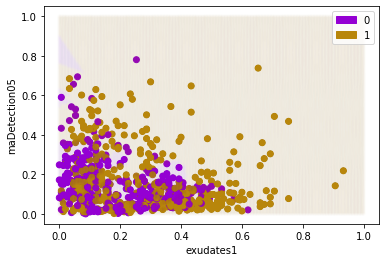

In [76]:
# Classify the full dataset on a 2D grid.
features = ['maDetection05', 'exudates1']
x = diabetes_X_scaled[features].to_numpy() # convert to Numpy Array
# indexes for features 0 and 1 for later slicing
f0 = diabetes_X_scaled.columns.get_loc(features[0])
f1 = diabetes_X_scaled.columns.get_loc(features[1]) 

C = 2
best_k_euclid = 13 # results from euclidean distance validation

# Get axis values
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

# Feature values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T


model = KNN(K=best_k_euclid, dist_fn=KNN.euclidean)

# Training set labels labels 

diabetes_y_prob, knns = model.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
diabetes_y_pred = np.argmax(diabetes_y_prob, axis=-1)
correct = diabetes_test_y == diabetes_y_pred
incorrect = np.logical_not(correct)   

diabetes_y_pred = np.argmax(diabetes_y_prob, axis=-1)
accuracy = np.sum(diabetes_y_pred == diabetes_test_y)/diabetes_test_y.shape[0]
acc = f'K={best_k_euclid} accuracy: {accuracy*100:.1f}.'
print(acc)

# get class probability of all the points in the 2D grid
important_features_X = diabetes_train_X_scaled[:,[f0,f1]]
print("important_features_X shape", important_features_X.shape)
print("x_all shape", x_all.shape)
y_pred_all, _ = model.fit(important_features_X, diabetes_train_y).predict_labels(x_all)

# PLOTTING CODE
plt.clf()

# Color encode y values
colors = {
    0: 'darkviolet',
    1: 'darkgoldenrod',
}

y_train_color_code = np.where(diabetes_train_y==0, colors[0], colors[1])
y_all_color_code = np.where(y_pred_all==0, colors[0], colors[1])

# Training datapoints
plt.scatter(important_features_X[:,0], important_features_X[:,1], c=y_train_color_code, marker='o', alpha=1)
# Background datapoints
plt.scatter(x_all[:,0], x_all[:,1], c=y_all_color_code, marker='.', alpha=.01)

plt.ylabel(features[0])
plt.xlabel(features[1])

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=item) for item in colors.values()]
label = colors.keys()
plt.legend(handles, label, loc='upper right', prop={'size': 10})
plt.savefig("knn_diabetes_decision_boundary_graph.png")
plt.show()



**Conclusion**: The top important features have positive correlation with target, so datapoints closer to origin are likely to be negative (label 0).

##Decision Tree - Diabetes
Our data set is larger, so we can use a validation set separated from the original training and test data to evaluate different values for the hyperparameters `max_depth` and `min_leaf_length`. 


In [77]:
acc, dep, leaff = decision_tree_selection(12, 3, diabetes_train_X_scaled, diabetes_train_y, diabetes_valid_X_scaled, diabetes_valid_y)
print(f'accuracy is {acc*100:.1f}% using max_depth = {dep} and min_leaf_length = {leaff} using cost function misclassification')

accuracy is 67.9% using max_depth = 10 and min_leaf_length = 1 using cost function misclassification


In [78]:
acc, dep, leaff = decision_tree_selection(12, 3, diabetes_train_X_scaled, diabetes_train_y, diabetes_valid_X_scaled, diabetes_valid_y, cost_function = DecisionTree.entropy)
print(f'accuracy is {acc*100:.1f}% using max_depth = {dep} and min_leaf_length = {leaff} using cost function entropy')

accuracy is 66.8% using max_depth = 4 and min_leaf_length = 1 using cost function entropy


In [79]:
acc, dep, leaff = decision_tree_selection(12, 3, diabetes_train_X_scaled, diabetes_train_y, diabetes_valid_X_scaled, diabetes_valid_y, cost_function = DecisionTree.gini)
print(f'accuracy is {acc*100:.1f}% using max_depth = {dep} and min_leaf_length = {leaff} using cost function gini index')

accuracy is 66.8% using max_depth = 4 and min_leaf_length = 1 using cost function gini index


We observe that
- minleaf_value for all three cost functions is 1
- max_depth for misclassification cost function is 10 (yielding highest validation accuracy of 67.9%)
- max_depth for gini index and entropy is 4
(yielding highest validation accuract of 66.8%)

Now we graph them:
- since gini index and entropy gives the same result, we'll just plot entropy. 

**Conclusion:** the best performance is obtained with a Decision tree that has maximum depth 10, node minumum node size 1 and Misclassification cost. Moving onwards, our benchmark model will be *Misclassification/max depth 4/ instances 1*

### Plotting accuracy as a function of parameters

best depth = 10, test accuracy = 0.6536796536796536


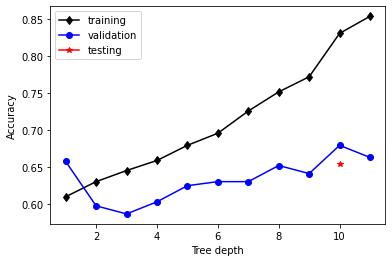

In [80]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = diabetes_train_y.shape[0]
n_valid = diabetes_valid_y.shape[0]

for k in range(1, 12):
    dt = DecisionTree(max_depth=k)

    diabetes_train_y_prob = dt.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_train_X_scaled)
    diabetes_train_y_pred = np.argmax(diabetes_train_y_prob, axis=-1)
    acc_tr = np.sum(diabetes_train_y_pred == diabetes_train_y)/n_train

    diabetes_valid_y_prob = dt.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_valid_X_scaled)
    diabetes_valid_y_pred = np.argmax(diabetes_valid_y_prob, axis=-1)
    acc_va = np.sum(diabetes_valid_y_pred == diabetes_valid_y)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
diabetes_test_y_prob = dt.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
diabetes_test_y_pred = np.argmax(diabetes_test_y_prob, axis=-1)
test_accuracy = np.sum(diabetes_test_y_pred ==diabetes_test_y)/diabetes_test_y.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('diabetes_DT_chooseDepth_misclass.png',dpi=300,bbox_inches='tight')

best depth = 4, test accuracy = 0.5974025974025974


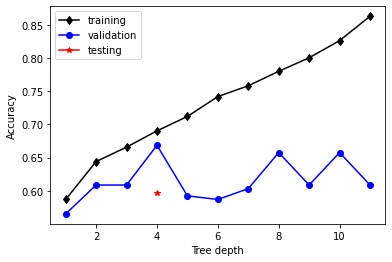

In [81]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = diabetes_train_y.shape[0]
n_valid = diabetes_valid_y.shape[0]

for k in range(1, 12):
    dt = DecisionTree(max_depth=k, cost_fn = cost_entropy)

    diabetes_train_y_prob = dt.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_train_X_scaled)
    diabetes_train_y_pred = np.argmax(diabetes_train_y_prob, axis=-1)
    acc_tr = np.sum(diabetes_train_y_pred == diabetes_train_y)/n_train

    diabetes_valid_y_prob = dt.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_valid_X_scaled)
    diabetes_valid_y_pred = np.argmax(diabetes_valid_y_prob, axis=-1)
    acc_va = np.sum(diabetes_valid_y_pred == diabetes_valid_y)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
diabetes_test_y_prob = dt.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
diabetes_test_y_pred = np.argmax(diabetes_test_y_prob, axis=-1)
test_accuracy = np.sum(diabetes_test_y_pred ==diabetes_test_y)/diabetes_test_y.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('diabetes_DT_chooseDepth_entropy.png',dpi=300,bbox_inches='tight')



### DT Decision Boundary (Diabetes Dataset)

Max depth=10 Min leaf instances=1 accuracy: 65.4.
important_features_X shape (736, 2)
x_all shape (40000, 2)


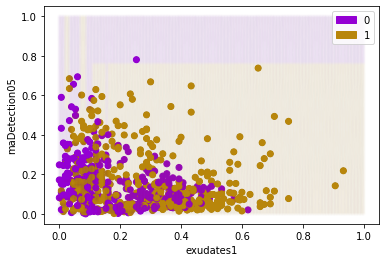

In [82]:
#Classify the full dataset on a 2D grid.
features = ['maDetection05', 'exudates1']
x = diabetes_X_scaled[features].to_numpy() # convert to Numpy Array
# indexes for features 0 and 1 for later slicing
f0 = diabetes_X_scaled.columns.get_loc(features[0])
f1 = diabetes_X_scaled.columns.get_loc(features[1]) 
  
max_depth = 10
min_leaf_instances =  1
COST = DecisionTree.misclassif
 
# Get axis values
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

# Feature values as a mesh
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T


model = DecisionTree(max_depth=max_depth, min_leaf_instances=min_leaf_instances, cost_fn=COST)

# Training set labels labels 

diabetes_y_prob = model.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
diabetes_y_pred = np.argmax(diabetes_y_prob, axis=-1)
correct = diabetes_test_y == diabetes_y_pred
incorrect = np.logical_not(correct)     

accuracy = np.sum(diabetes_y_pred == diabetes_test_y)/diabetes_test_y.shape[0]
acc = f'Max depth={max_depth} Min leaf instances={min_leaf_instances} accuracy: {accuracy*100:.1f}.'
print(acc) 

# get class probability of all the points in the 2D grid
important_features_X = diabetes_train_X_scaled[:,[f0,f1]]
print("important_features_X shape", important_features_X.shape)
print("x_all shape", x_all.shape)
y_pred_all = model.fit(important_features_X, diabetes_train_y).predict(x_all)
y_pred = np.argmax(y_pred_all, axis=-1)

# PLOTTING CODE
plt.clf()

# Color encode y values
colors = {
    0: 'darkviolet',
    1: 'darkgoldenrod',
}

y_train_color_code = np.where(diabetes_train_y==0, colors[0], colors[1])
y_all_color_code = np.where(y_pred==0, colors[0], colors[1])

# Training datapoints
plt.scatter(important_features_X[:,0], important_features_X[:,1], c=y_train_color_code, marker='o', alpha=1)
# Background datapoints
plt.scatter(x_all[:,0], x_all[:,1], c=y_all_color_code, marker='.', alpha=.01)

plt.ylabel(features[0])
plt.xlabel(features[1])

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=item) for item in colors.values()]
label = colors.keys()
plt.legend(handles, label, loc='upper right', prop={'size': 10})

plt.savefig('diabetes_decision_boundary_misclassif.png')

## Model Comparison - Diabetes data set

We now take the models with the best parameters after validation, and compare their AUROC performance.

DT testing accuracy	 0.6536796536796536
KNN testing accuracy	 0.696969696969697


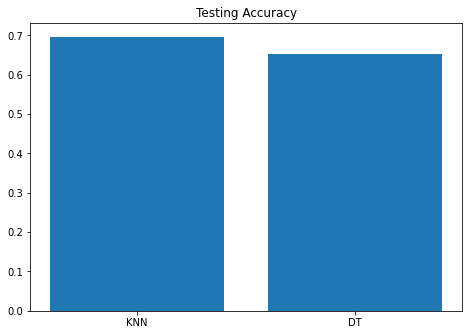

In [83]:
# Compare Testing Accuracy of our best 2 models
best_KNN = KNN(K=13, dist_fn=KNN.euclidean)
best_DT = DecisionTree(max_depth=10, min_leaf_instances=1, cost_fn=DecisionTree.misclassif)

DT_y_prob = best_DT.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
DT_y_pred = np.argmax(DT_y_prob, axis=-1)
DT_testing_acc = best_DT.evaluate_acc(diabetes_test_y, DT_y_pred)

KNN_y_prob, _ = best_KNN.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
KNN_y_pred = np.argmax(KNN_y_prob, axis=-1)
KNN_testing_acc = best_KNN.evaluate_acc(diabetes_test_y, KNN_y_pred)

print("DT testing accuracy\t", DT_testing_acc)
print("KNN testing accuracy\t", KNN_testing_acc)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['KNN', 'DT']
testing_acc = [KNN_testing_acc, DT_testing_acc]
ax.bar(models, testing_acc)
ax.set_title("Testing Accuracy")

plt.show()

DT score	 0.6537106446776612
KNN score	 0.6969640179910045


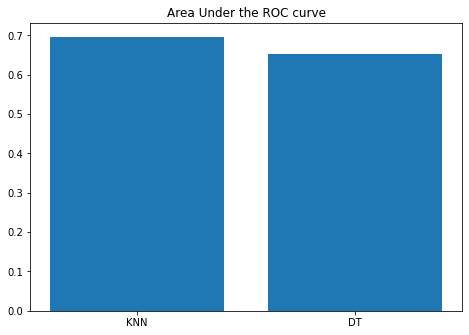

In [84]:
# Compare AUROC performance of our best 2 models
# Plot their performance in a graph
from sklearn.metrics import roc_auc_score

best_KNN = KNN(K=13, dist_fn=KNN.euclidean)
best_DT = DecisionTree(max_depth=10, min_leaf_instances=1, cost_fn=DecisionTree.misclassif)

DT_y_prob = best_DT.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
DT_y_pred = np.argmax(DT_y_prob, axis=-1)
DT_auroc = roc_auc_score(diabetes_test_y, DT_y_pred)

KNN_y_prob, _ = best_KNN.fit(diabetes_train_X_scaled, diabetes_train_y).predict(diabetes_test_X_scaled)
KNN_y_pred = np.argmax(KNN_y_prob, axis=-1)
KNN_auroc = roc_auc_score(diabetes_test_y, KNN_y_pred)

print("DT score\t", DT_auroc)
print("KNN score\t", KNN_auroc)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['KNN', 'DT']
AUROC = [KNN_auroc, DT_auroc]
ax.bar(models, AUROC)
ax.set_title("Area Under the ROC curve")

plt.show()

**Conclusion:** for the given dataset, K-Nearest Neighbors appear to be a better model for classification of the Diabetes Dara set.

# Data Set 2: Hepatitis
**Dataset description:** there is not much information available about this dataset other than the description of the features and target label. These features correspond to some biometric measurement of a person, and the target label is a binary class representing whether the person eventually died (1) or lived (2). These integer-encoded features are subsequently encoded into 0 and 1 in this notebook.

## Acquire, Preprocess and Analyze the data

In [85]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data'
colNames = ['class','age','sex','steroid','antivirals','fatigue','malaise','anorexia','liverBig','liverFirm','spleenPalpable','spiders','ascites','varices','bilirubin','alkPhosphate','sgot','albumin','protime','histology']
hepatitisRaw = pd.read_csv(url, header=None, names=colNames) # 155 observations
hepatitis = hepatitisRaw[~hepatitisRaw.eq('?').any(1)] #removing rows with "?" values
hepatitis.reset_index(drop=True, inplace=True)
hepatitis # 80 observations remaining

,class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liverBig,liverFirm,spleenPalpable,spiders,ascites,varices,bilirubin,alkPhosphate,sgot,albumin,protime,histology
0,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.90,95,28,4.0,75,1
1,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.30,78,30,4.4,85,1
2,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.00,59,249,3.7,54,1
3,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.90,81,60,3.9,52,1
4,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.20,57,144,4.9,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.30,85,44,4.2,85,2
76,1,49,1,1,2,1,1,2,2,2,1,1,2,2,1.40,85,70,3.5,35,2
77,2,31,1,1,2,1,2,2,2,2,2,2,2,2,1.20,75,173,4.2,54,2
78,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2


In [86]:
# Convert datatypes to numerical (int, float)
for col in hepatitis.columns:
  hepatitis[col] = pd.to_numeric(hepatitis[col])
hepatitis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class           80 non-null     int64  
 1   age             80 non-null     int64  
 2   sex             80 non-null     int64  
 3   steroid         80 non-null     int64  
 4   antivirals      80 non-null     int64  
 5   fatigue         80 non-null     int64  
 6   malaise         80 non-null     int64  
 7   anorexia        80 non-null     int64  
 8   liverBig        80 non-null     int64  
 9   liverFirm       80 non-null     int64  
 10  spleenPalpable  80 non-null     int64  
 11  spiders         80 non-null     int64  
 12  ascites         80 non-null     int64  
 13  varices         80 non-null     int64  
 14  bilirubin       80 non-null     float64
 15  alkPhosphate    80 non-null     int64  
 16  sgot            80 non-null     int64  
 17  albumin         80 non-null     float

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Feature Distribution 

#### Categorical 

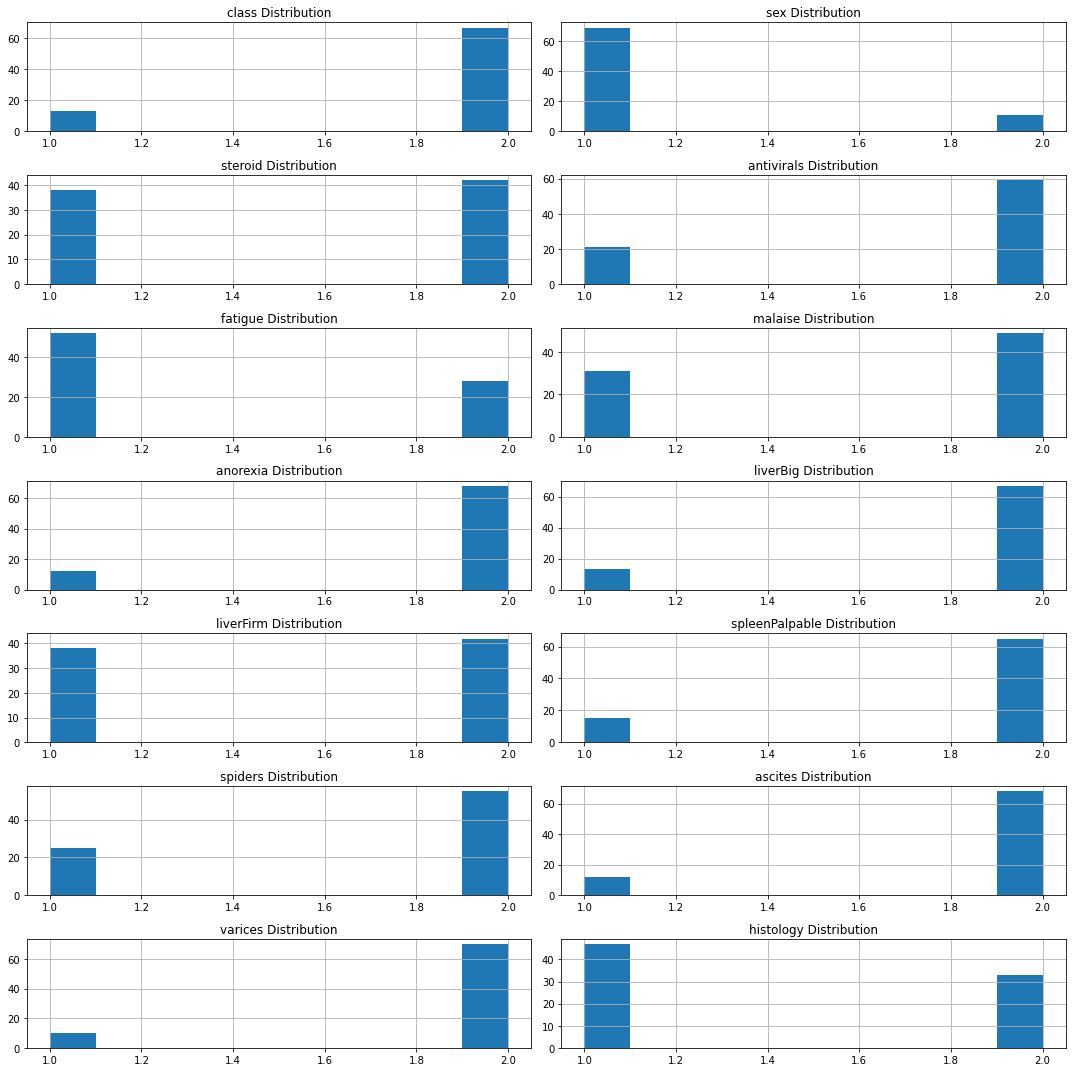

In [87]:
cat_features = ["class","sex","steroid","antivirals","fatigue","malaise","anorexia","liverBig","liverFirm","spleenPalpable","spiders","ascites","varices","histology"]
draw_distributions(hepatitis, cat_features, 7, 2)

####Numerical

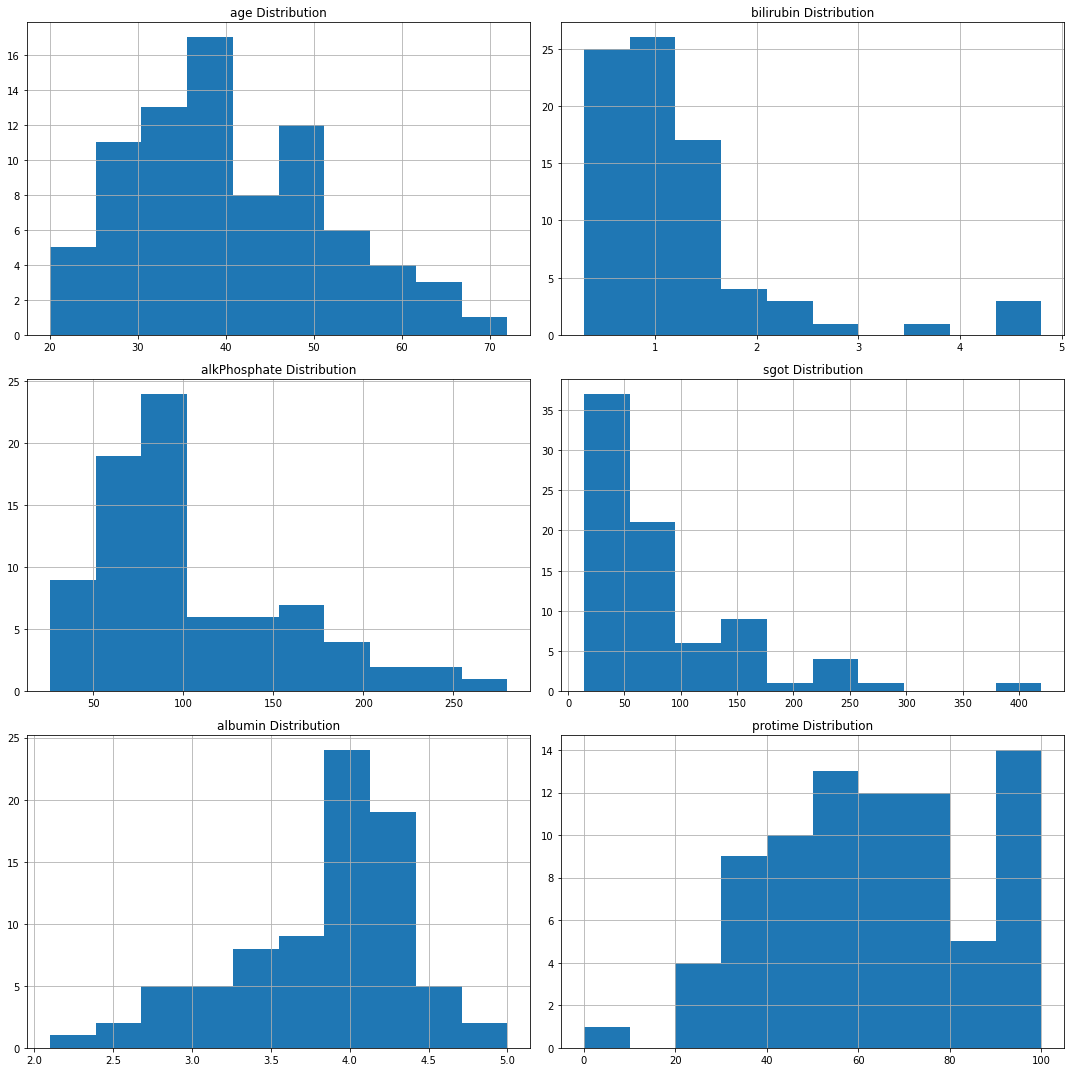

In [88]:
num_features = ['age', 'bilirubin','alkPhosphate', 'sgot', 'albumin', 'protime']
draw_distributions(hepatitis, num_features, 3, 2)

- Most numerical features are right skewed; however the two most important features `albumin` and `protime` (as we will se later in the notebook) are left skewed.

## Running Experiments

### Train-Test split

For comparability, we want to make sure to use the same split for both KNN and DecisionTree models.

In [89]:
from sklearn.model_selection import train_test_split
RAND_SEED = 1234

hepatitis_y = hepatitis['class']
hepatitis_y = hepatitis_y.replace([2,1], [1, 0]) # encode 1,2 into 0,1
hepatitis_x = normalize_features(hepatitis, 'class') # scale into [0, 1.0] range

#print the feature shape and classes of hepatitis 
(N,D), C = hepatitis_x.shape, np.max(hepatitis_y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

# Split 80/20 train/test
hepatitis_train_X, hepatitis_test_X, hepatitis_train_y, hepatitis_test_y = \
    train_test_split(hepatitis_x, hepatitis_y, test_size=0.2, random_state=RAND_SEED)

# Split 80/20 train/validation
# hepatitis_train_X, hepatitis_valid_X, hepatitis_train_y, hepatitis_valid_y = \
#     train_test_split(hepatitis_train_X, hepatitis_train_y, test_size=0.2, random_state=RAND_SEED)

hepatitis_train_X = hepatitis_train_X.to_numpy()
hepatitis_train_y = hepatitis_train_y.to_numpy()

# hepatitis_valid_X = hepatitis_valid_X.to_numpy()
# hepatitis_valid_y = hepatitis_valid_y.to_numpy()

hepatitis_test_X = hepatitis_test_X.to_numpy()
hepatitis_test_y = hepatitis_test_y.to_numpy()

proportion_positive = hepatitis_train_y.sum() / hepatitis_train_y.shape[0]
proportion_negative = 1 - proportion_positive
print("Training set positive:", proportion_positive*100,"%")
print("Training set negative:", proportion_negative*100,'%')
print()
print("Train set size", len(hepatitis_train_y))
print("Test set size", len(hepatitis_test_y))

instances (N) 	 80 
 features (D) 	 19 
 classes (C) 	 2
Training set positive: 84.375 %
Training set negative: 15.625 %

Train set size 64
Test set size 16


## KNN - Hepatitis

### Choosing Best K with K Fold cross validation

Since our data set size is relatively small (N=80), we make an effort to use as much of our available data for training.

For this reason we do not use a separate validation set, instead we perform K-fold cross validation on the training set with k=5 folds.

In [90]:
# SAME RESULT AS BELOW BUT USING NUMPY STRUCTURES. 
# FINDS ONE SINGLE K FOR EVERY FOLD
from sklearn.model_selection import KFold

def cross_validate_KNN(x_train, y_train, num_of_folds=5, max_k_to_test=20, dist_function=KNN.euclidean):
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=1234)

  crossVal = np.zeros((num_of_folds, max_k_to_test+1)) # i-th row has max_k_to_test validation accuracies
  currentFold = 0
  for train, validate in kf.split(x_train):
    # N=51 training, N~=13 validation
    # For every fold, obtain validation accuracies for all values of K
    x_train_tr, y_train_tr = x_train[train], y_train[train]
    x_train_va, y_train_va = x_train[validate], y_train[validate]

    n_valid = y_train_va.shape[0]
    for k in range(1, max_k_to_test + 1):
        # KNN with k=k tested on current Fold
        knn = KNN(K=k, dist_fn=dist_function)
        y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va)
        y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
        accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
        crossVal[currentFold, k] = accuracy
    
    # Best k for this fold
    kAccuracies = crossVal[currentFold,:] # row
    bestKFold = np.argmax(kAccuracies)

    currentFold += 1

  # print(pd.DataFrame(crossVal))

  # Every column corresponds to a value of parameter K.
  avgAccuracies = np.mean(crossVal, axis=0) # compute fold-wise means
  bestGlobalK = np.argmax(avgAccuracies)
  return bestGlobalK, avgAccuracies

best_k_euclidean , accuracies_euclidean = cross_validate_KNN(hepatitis_train_X, hepatitis_train_y)
best_k_cosine , accuracies_cosine = cross_validate_KNN(hepatitis_train_X, hepatitis_train_y, dist_function=KNN.cosine)
best_k_manhattan , accuracies_manhattan = cross_validate_KNN(hepatitis_train_X, hepatitis_train_y, dist_function=KNN.manhattan)

print("Euclidean best K:", best_k_euclidean, "\tvalidation accuracy:", accuracies_euclidean[best_k_euclidean])
print("Cosine distance best K:", best_k_cosine, "\tvalidation accuracy:", accuracies_cosine[best_k_cosine])
print("Manhattan distance best K:", best_k_manhattan, "\tvalidation accuracy:", accuracies_manhattan[best_k_manhattan])

Euclidean best K: 7 	validation accuracy: 0.8615384615384615
Cosine distance best K: 8 	validation accuracy: 0.8602564102564102
Manhattan distance best K: 7 	validation accuracy: 0.876923076923077


Test accuracy with K=7 and Manhattan distance: 0.875


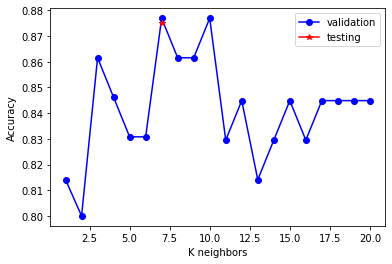

In [91]:
# our validation step above returns:
# Manhattan distance best K: 7 	validation accuracy: 0.876923076923077
knn = KNN(K=7, dist_fn=KNN.manhattan)
knn.fit(hepatitis_train_X, hepatitis_train_y)

y_test_pred, _ = knn.predict_labels(hepatitis_test_X)
test_accuracy = knn.evaluate_acc(y_test_pred, hepatitis_test_y)
print(f"Test accuracy with K={7} and Manhattan distance: {test_accuracy}")
# dropping the first value as it always zero
plot_validation(list(range(1, 21)), accuracies_manhattan[1:], 7, test_accuracy, param_label="K neighbors", file_name="knn_hepatitis_acc_against_k")

In [92]:
# IMPLEMENTATION USING NATIVE PYTHON STRUCTURES
from sklearn.model_selection import KFold

def cross_validate_KNN_impl2(x_train, y_train, num_of_folds=5, max_k_to_test=20, dist_function=KNN.euclidean):
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=1234)

  fold_results = []

  for train, validate in kf.split(x_train):
    # For every fold, obtain validation accuracies for all values of K
    x_train_tr, y_train_tr = x_train[train], y_train[train]
    x_train_va, y_train_va = x_train[validate], y_train[validate]

    model_choices = []
    valid_acc = []

    n_valid = y_train_va.shape[0]

    for k in range(1, max_k_to_test+1):
        # KNN with k=k tested on current Fold
        knn = KNN(K=k, dist_fn=dist_function)
        y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va)
        y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
        accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
        model_choices.append(k)
        valid_acc.append(accuracy)

    fold_results.append(valid_acc)

    best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
    knn = KNN(K=best_valid_K)
    y_test_prob,_ = knn.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
    y_test_pred = np.argmax(y_test_prob, axis=-1)
    test_accuracy = np.sum(y_test_pred == hepatitis_test_y)/hepatitis_test_y.shape[0]
    # print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

  accuracy_total = [0] * (max_k_to_test)

  for fold in range(0, num_of_folds):
    for k in range(0, max_k_to_test):
      accuracy_total[k] = accuracy_total[k] + fold_results[fold][k]

  accuracy_avg = []

  for total in accuracy_total:
    accuracy_avg.append(total / num_of_folds)

  max_accuracy_k = []
  highest_accuracy = accuracy_avg[np.argmax(accuracy_avg, axis=0)]
  for index, val in enumerate(accuracy_avg):
    if val == highest_accuracy:
      max_accuracy_k.append(index + 1)

  print("Maximal accuracy obtained with k = " + str(max_accuracy_k))

  return max_accuracy_k, highest_accuracy


print("Euclidean distance\n",cross_validate_KNN_impl2(hepatitis_train_X, hepatitis_train_y))
print("Cosine distance\n",cross_validate_KNN_impl2(hepatitis_train_X, hepatitis_train_y, dist_function=KNN.cosine))
print("Manhattan distance\n",cross_validate_KNN_impl2(hepatitis_train_X, hepatitis_train_y, dist_function=KNN.manhattan))

Maximal accuracy obtained with k = [7]
Euclidean distance
 ([7], 0.8615384615384615)
Maximal accuracy obtained with k = [8, 15, 16]
Cosine distance
 ([8, 15, 16], 0.8602564102564102)
Maximal accuracy obtained with k = [7, 10]
Manhattan distance
 ([7, 10], 0.876923076923077)


**Validation results:** 
The best KNN model is achieved with **K=7** and **Manhattan** distance, obtaining a maximal average accuracy of 87.69%

### KNN Decision Boundary

We now plot the decision boundary for KNN and Hepatitis Dataset. To have an interpretable plot, we will first identify the 2 most important predictors and plot a 2d graph. We use a Random Forest to find the best predictors.


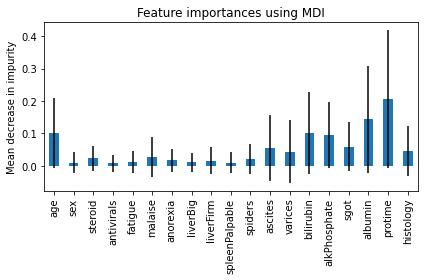

In [93]:
# Find Top features using Random Forest feature importance
from sklearn.ensemble import RandomForestClassifier
y = hepatitis['class']
X = hepatitis.loc[:, hepatitis.columns!= 'class']
forest = RandomForestClassifier(random_state=1234)

forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("knn_hepatitis_random_forest.png")

**Feature importance results**

The Random Forest finds the features with greatest mean decrease in impurity (importance) to be:  
- `protime`: records prothrombin time test results. Prothrombin is a protein produced by the liver, and is important for blod clotting. The values represent number of seconds it takes for a blood sample to clot.
- `albumin`: records albumin levels. Albumin is a protein produced by the liver. Low albumin levels can be a sign of liver or kidney disease. High levels may be a sign of dehydration.

**Produce the plot:**

K=7 accuracy: 87.5.
important_features_X shape (64, 2)
x_all shape (40000, 2)


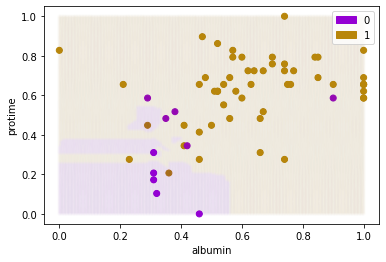

In [94]:
# Classify the full dataset on a 2D grid.
features = ['protime', 'albumin']
x = hepatitis_x[features].to_numpy() # convert to Numpy Array
# indexes for features 0 and 1 for later slicing
f0 = hepatitis_x.columns.get_loc(features[0])
f1 = hepatitis_x.columns.get_loc(features[1]) 

C = 2
best_k = 7
COST = KNN.manhattan

# Get axis values
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

# Feature values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T


model = KNN(K=best_k, dist_fn=COST)

# Training set labels
hepatitis_y_prob, knns = model.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
hepatitis_y_pred = np.argmax(hepatitis_y_prob, axis=-1)
correct = hepatitis_test_y == hepatitis_y_pred
incorrect = np.logical_not(correct)   

hepatitis_y_pred = np.argmax(hepatitis_y_prob, axis=-1)
accuracy = np.sum(hepatitis_y_pred == hepatitis_test_y)/hepatitis_test_y.shape[0]
acc = f'K={best_k} accuracy: {accuracy*100:.1f}.'
print(acc)

# get class probability of all the points in the 2D grid
important_features_X = hepatitis_train_X[:,[f0,f1]]
print("important_features_X shape", important_features_X.shape)
print("x_all shape", x_all.shape)
y_pred_all, _ = model.fit(important_features_X, hepatitis_train_y).predict_labels(x_all)

# PLOTTING CODE
plt.clf()

# Color encode y values
colors = {
    0: 'darkviolet',
    1: 'darkgoldenrod',
}

y_train_color_code = np.where(hepatitis_train_y==0, colors[0], colors[1])
y_all_color_code = np.where(y_pred_all==0, colors[0], colors[1])

# Training datapoints
plt.scatter(important_features_X[:,0], important_features_X[:,1], c=y_train_color_code, marker='o', alpha=1)
# Background datapoints
plt.scatter(x_all[:,0], x_all[:,1], c=y_all_color_code, marker='.', alpha=.01)

plt.ylabel(features[0])
plt.xlabel(features[1])

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=item) for item in colors.values()]
label = colors.keys()
plt.legend(handles, label, loc='upper right', prop={'size': 10})
plt.savefig('knn_hepatitis_decision_boundary.png')
plt.show()

**Conclusion**: Datapoints with lower values of both features are classified as healthy (0), while datapoints having a relatively high value for either of these features is classified as hepatitis risk (1).

## Decision Tree - Hepatitis

### Choosing best `max_depth` and `min_instances` parameters using Kfold Validation

Following the previous section's logic, we will use cross validation so as to use as much data for training as possible.

Since we have two hyperparameters to evaluate, we have to try out combinations of both maximum depth and minimum instances in a node.

Heuristically, we pick a range of 6 for depth (which can give us 2^6=64 region nodes), and a range of 10 for the number of examples in node, which represents about 20% of the training set for validation.

In [95]:
# Cross validation
from sklearn.model_selection import KFold

def cross_validate_DT(x_train, y_train, num_of_folds=5, depth_range=6, instances_range=10, cost_fn=DecisionTree.entropy):
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=1234)
  
  # For every fold there is a matrix of size depthxinstances
  crossVal = np.zeros((num_of_folds, depth_range+1, instances_range+1)) # i-th matrix has the accuracies for combinations of depthxinstances
  currentFold = 0

  for train, validate in kf.split(x_train):
    # N=51 training, N~=13 validation
    # For every fold, obtain validation accuracies for all values of K
    x_train_tr, y_train_tr = x_train[train], y_train[train]
    x_train_va, y_train_va = x_train[validate], y_train[validate]

    n_valid = y_train_va.shape[0]

    for depth in range(1, depth_range+1):
      for instances in range(1, instances_range+1):
        # Train a decision tree with current parameters
        DT = DecisionTree(num_classes=2, max_depth=depth, min_leaf_instances=instances, cost_fn=cost_fn)
        y_train_va_prob = DT.fit(x_train_tr, y_train_tr).predict(x_train_va)
        y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
        accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid

        crossVal[currentFold, depth, instances] = accuracy
    
    currentFold += 1

  # For every parameter combination we compute the fold-wise mean accuracy
  avgAccuracies = np.mean(crossVal, axis=0) # compute fold-wise means

  # Find indexes of maximal average accuracy
  # Same result as lines 45-46
  # avg_best_depth, avg_best_instances = -1, -1
  # max_accuracy = -1
  # for i in range(avgAccuracies.shape[0]):
  #   for j in range(avgAccuracies.shape[1]):
  #     if avgAccuracies[i, j] > max_accuracy:
  #       avg_best_depth = i
  #       avg_best_instances = j
  #       max_accuracy = avgAccuracies[i, j]
  
  bestResultIndex = np.argmax(avgAccuracies) # finds max index of flattened array
  best_depth, best_instances = np.unravel_index([bestResultIndex], avgAccuracies.shape, order='C')

  return best_depth, best_instances, avgAccuracies[best_depth, best_instances], avgAccuracies

depth, instances, accuracy, avgAccuracies = cross_validate_DT(hepatitis_train_X, hepatitis_train_y)
print("DT WITH ENTROPY")
print("best depth \t", depth)
print("best min instances \t", instances)
print("best accuracy\t", accuracy)

depth, instances, accuracy, avgAccuracies = cross_validate_DT(hepatitis_train_X, hepatitis_train_y, cost_fn=DecisionTree.gini)
print("DT WITH GINI IMPURITY")
print("best depth \t", depth)
print("best min instances \t", instances)
print("best accuracy\t", accuracy)

depth, instances, accuracy, avgAccuracies = cross_validate_DT(hepatitis_train_X, hepatitis_train_y, cost_fn=DecisionTree.misclassif)
print("DT WITH MISCLASSIFICATION")
print("best depth \t", depth)
print("best min instances \t", instances)
print("best accuracy\t", accuracy)


DT WITH ENTROPY
best depth 	 [2]
best min instances 	 [1]
best accuracy	 [0.84487179]
DT WITH GINI IMPURITY
best depth 	 [3]
best min instances 	 [9]
best accuracy	 [0.84358974]
DT WITH MISCLASSIFICATION
best depth 	 [4]
best min instances 	 [1]
best accuracy	 [0.84487179]


**Validation Results:**
The best obtainable average accuracy over the k folds is 84.49%.
This is tied between the model using entropy and the model using misclassification, but we will prefer the latter, since it has a larger depth and thus has a reduced risk of underfitting, given the number of features in our dataset.

Moving onward, we will take the best model to be *Misclassification/depth=4/instances=1*.


### Accuracy as a function of `max_depth` and `min_leaf_instances`
We now visualize how model accuracy changes as we change both parameters.

For this we show two line plots, each with one of the other parameters fixed at the best possible value.

In [96]:
best_DT = DecisionTree(max_depth=4, min_leaf_instances=1, cost_fn=DecisionTree.misclassif)
DT_y_prob = best_DT.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
DT_y_pred = np.argmax(DT_y_prob, axis=-1)
DT_test_accuracy = (DT_y_pred == hepatitis_test_y).sum() / len(hepatitis_test_y)
print("Best model accuracy on test set:", DT_test_accuracy)

Best model accuracy on test set: 0.875


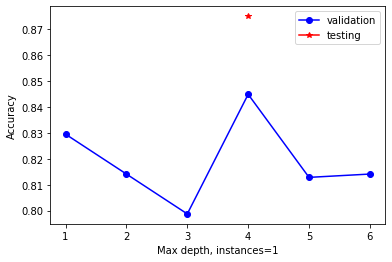

In [97]:
# Plot validation accuracy as we vary over the maximum depth
depth_range = 6
depth, instances, best_accuracy, avgAccuracies = cross_validate_DT(hepatitis_train_X, hepatitis_train_y, cost_fn=DecisionTree.misclassif, depth_range=depth_range)
# Accuracy as function of Depth
model_choices = [d for d in range(1, depth_range+1)]
validation_accuracies = avgAccuracies[1:,instances] # fixed instances=1
plot_validation(model_choices, validation_accuracies, best_validation_param = depth, test_accuracy=DT_test_accuracy, param_label='Max depth, instances=1', file_name="dt_hepatitis_max_leaf_acc.png")


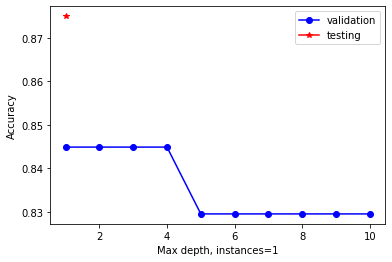

In [98]:
# Plot validation accuracy as we vary over the minimum leaf instances
instances_range = 10
depth, instances, best_accuracy, avgAccuracies = cross_validate_DT(hepatitis_train_X, hepatitis_train_y, cost_fn=DecisionTree.misclassif, instances_range=instances_range)
# Accuracy as function of Number of instances
model_choices = [i for i in range(1,11)] # instances from 1 to 10
validation_accuracies = avgAccuracies[depth,1:].T # fixed depth=4
plot_validation(model_choices, validation_accuracies, best_validation_param = instances, test_accuracy=DT_test_accuracy, param_label='Max depth, instances=1', file_name="dt_hepatitis_min_leaf_acc.png")

### DT Decision Boundary (Hepatitis Dataset)

Max depth=4 Min leaf instances=1 accuracy: 87.5.
important_features_X shape (64, 2)
x_all shape (40000, 2)


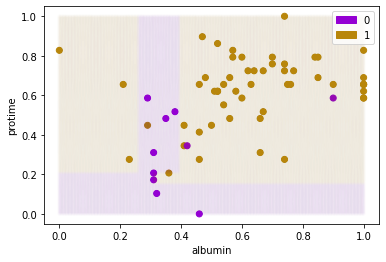

In [99]:
# Classify the full dataset on a 2D grid.
features = ['protime', 'albumin']
x = hepatitis_x[features].to_numpy() # convert to Numpy Array
# indexes for features 0 and 1 for later slicing
f0 = hepatitis_x.columns.get_loc(features[0])
f1 = hepatitis_x.columns.get_loc(features[1]) 

max_depth = 4
min_leaf_instances = 1
COST = DecisionTree.misclassif

# Get axis values
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

# Feature values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=max_depth, min_leaf_instances=min_leaf_instances, cost_fn=COST)

# Training set labels
hepatitis_y_prob = model.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
hepatitis_y_pred = np.argmax(hepatitis_y_prob, axis=-1)
correct = hepatitis_test_y == hepatitis_y_pred
incorrect = np.logical_not(correct)   

accuracy = np.sum(hepatitis_y_pred == hepatitis_test_y)/hepatitis_test_y.shape[0]
acc = f'Max depth={max_depth} Min leaf instances={min_leaf_instances} accuracy: {accuracy*100:.1f}.'
print(acc)

# get class probability of all the points in the 2D grid
important_features_X = hepatitis_train_X[:,[f0,f1]]
print("important_features_X shape", important_features_X.shape)
print("x_all shape", x_all.shape)
y_pred_all = model.fit(important_features_X, hepatitis_train_y).predict(x_all)

y_pred = np.argmax(y_pred_all, axis=-1)

# PLOTTING CODE
plt.clf()

# Color encode y values
colors = {
    0: 'darkviolet',
    1: 'darkgoldenrod',
}

y_train_color_code = np.where(hepatitis_train_y==0, colors[0], colors[1])
y_all_color_code = np.where(y_pred==0, colors[0], colors[1])

# Training datapoints
plt.scatter(important_features_X[:,0], important_features_X[:,1], c=y_train_color_code, marker='o', alpha=1)
# Background datapoints
plt.scatter(x_all[:,0], x_all[:,1], c=y_all_color_code, marker='.', alpha=.01)

plt.ylabel(features[0])
plt.xlabel(features[1])

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=item) for item in colors.values()]
label = colors.keys()
plt.legend(handles, label, loc='upper right', prop={'size': 10})
plt.savefig("dt_hepatitis_decision_boundary.png")
plt.show()

## Model Comparison - Hepatitis

We now take the models with the best parameters after validation, and compare their AUROC performance.

DT testing accuracy	 0.875
KNN testing accuracy	 0.875


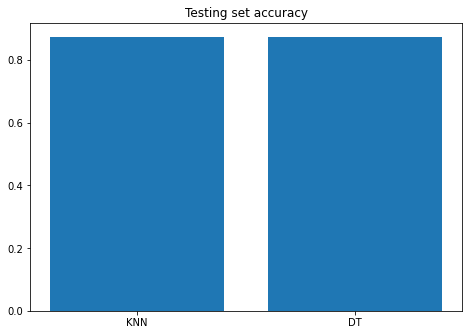

In [100]:
# Compare Testing accuracy of our best 2 models
# Compare testing_acc performance of our best 2 models

best_KNN = KNN(K=7, dist_fn=KNN.manhattan)
best_DT = DecisionTree(max_depth=4, min_leaf_instances=1, cost_fn=DecisionTree.misclassif)

DT_y_prob = best_DT.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
DT_y_pred = np.argmax(DT_y_prob, axis=-1)
DT_testing_acc = best_DT.evaluate_acc(hepatitis_test_y, DT_y_pred)

KNN_y_prob, _ = best_KNN.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
KNN_y_pred = np.argmax(KNN_y_prob, axis=-1)
KNN_testing_acc = best_KNN.evaluate_acc(hepatitis_test_y, KNN_y_pred) 

print("DT testing accuracy\t", DT_testing_acc)
print("KNN testing accuracy\t", KNN_testing_acc)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['KNN', 'DT']
testing_acc = [KNN_testing_acc, DT_testing_acc]
ax.bar(models, testing_acc)
ax.set_title("Testing set accuracy")

plt.show()

DT score	 0.7948717948717949
KNN score	 0.6666666666666667


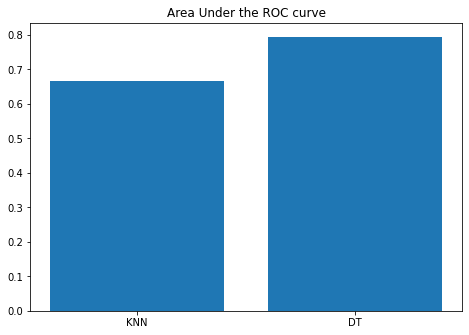

In [101]:
# Compare AUROC performance of our best 2 models
# Plot their performance in a graph
from sklearn.metrics import roc_auc_score

best_KNN = KNN(K=7, dist_fn=KNN.manhattan)
best_DT = DecisionTree(max_depth=4, min_leaf_instances=1, cost_fn=DecisionTree.misclassif)

DT_y_prob = best_DT.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
DT_y_pred = np.argmax(DT_y_prob, axis=-1)
DT_auroc = roc_auc_score(hepatitis_test_y, DT_y_pred)

KNN_y_prob, _ = best_KNN.fit(hepatitis_train_X, hepatitis_train_y).predict(hepatitis_test_X)
KNN_y_pred = np.argmax(KNN_y_prob, axis=-1)
KNN_auroc = roc_auc_score(hepatitis_test_y, KNN_y_pred) 

print("DT score\t", DT_auroc)
print("KNN score\t", KNN_auroc)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['KNN', 'DT']
AUROC = [KNN_auroc, DT_auroc]
ax.bar(models, AUROC)
ax.set_title("Area Under the ROC curve")

plt.show()

**Conclusion:** for this given dataset, Decision Trees appear to be a better model for classification of the Hepatitis Data set.